In [ ]:
import random
from typing import TypedDict

from IPython.display import Image
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph

**Data Processing (Sequential)** 

State é a memória compartilhada e viva do seu workflow, é a linha de trabalho, onde cada ferramenta (`NODE`)
pega o que precisa e deixa seu resultado para a próxima.

In [ ]:
class State(TypedDict):
    """Representa o estado compartilhado que flui através do grafo de processamento.

    Este dicionário atua como a memória central do workflow, onde cada nó
    pode ler informações de etapas anteriores e escrever seus resultados para
    etapas futuras.

    Attributes:
        input (int): O valor inicial fornecido ao grafo. Neste workflow,
            espera-se que seja um número (int ou float) para o cálculo inicial.
        output (int): O resultado da última operação executada. Cada nó
            atualiza este campo com seu próprio resultado, permitindo que o
            próximo nó o utilize.

    """

    input: int
    output: int

`NODE`: Os nós são as funções que realizam o trabalho de fato. Cada nó é uma "estação de trabalho" no seu fluxo

Análise Educativa: Observe o padrão fundamental em todos eles: uma função que recebe o **state** como argumento, executa sua tarefa e `retorna um dicionário apenas com as atualizações para o estado`. node_b, por exemplo, retorna {"output": output}, não o estado inteiro. O LangGraph cuida de fazer a "fusão" dessa atualização com o estado principal.



* `Start point: Start NODE`

In [ ]:
def node_a(state: State) -> State:
    """Processa o estado inicial adicionando um valor aleatório.

    Esta função representa um "nó" em um grafo de processamento. Sua principal
    responsabilidade é pegar um valor numérico do estado de entrada,
    adicionar um deslocamento (offset) aleatório a ele e, em seguida,
    retornar um novo estado contendo o resultado.

    A função também imprime no console as etapas do seu cálculo para
    facilitar o rastreamento e a depuração do fluxo de dados, o que é
    uma prática muito útil ao trabalhar com sistemas complexos como LangGraph.

    Exemplo de uso:
        Se o estado de entrada for `State(input=10)` e o offset aleatório
        gerado for `5`, a função imprimirá os detalhes da operação e
        retornará `State(output=15)`.

    Args:
        state (State): Um objeto (provavelmente um dicionário ou TypedDict)
            que representa o estado atual do grafo. Espera-se que este
            objeto contenha uma chave 'input' com um valor numérico.

    Returns:
        State: Um novo objeto de estado contendo o resultado da operação.
            A chave 'output' conterá a soma do 'input' original com o
            offset aleatório gerado.

    """
    input_value = state["input"]
    offset = random.randint(1, 10)
    output = input_value + offset
    print(f"NODE A:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return State(output=output)

In [ ]:
def node_b(state: State):
    input_value = state["output"]
    offset = random.randint(1, 10)
    output = input_value + offset
    print(f"NODE B:\n ->input:{input_value}\n ->offset:{offset}\n ->output:{output}\n ")
    return {"output": output}

O `workflow = StateGraph(...)` é a criação da "planta da fábrica". As arestas (`.add_edge()`) são as "esteiras rolantes" que conectam as estações de trabalho em uma sequência.

In [ ]:
workflow = StateGraph(state_schema=State)

In [ ]:
workflow.add_node(node_a)
workflow.add_node(node_b)

.add_edge é como o pathway (o caminho) entre os nós:

START *----> `NODE_a`---->(add_edge) *`NODE_b`---->END

O workflow começa na partida (`START`), então:

1. Adicionamos uma edge para o NODE_a.

2. O `NODE_a` executa seu processamento e entrega uma atualização com seus resultados (por exemplo: {'output': 8}).

3. O LangGraph recebe essa atualização e modifica o Estado Inteiro, que agora está atualizado e pronto para o próximo passo.

4. Adicionamos uma nova edge para ligar ao `NODE_b`.

5. O `NODE_b` recebe o Estado Inteiro já atualizado pelo passo anterior, faz seu trabalho e entrega sua própria atualização.

6. O LangGraph atualiza o Estado novamente.

Finalmente, adicionamos uma edge ao final do workflow, END.

In [ ]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

In [ ]:
graph = workflow.compile()

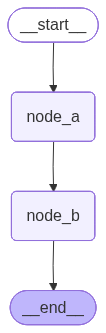

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke(
    input={
        "input": 1,
    },
)

NODE A:
 ->input:1
 ->offset:6
 ->output:7
 
NODE B:
 ->input:7
 ->offset:8
 ->output:15
 


{'input': 1, 'output': 15}

**Call LLMs**

In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [ ]:
class State(TypedDict):
    """Representa o estado do nosso grafo (workflow).

    Attributes:
        question: A pergunta a ser respondida.
        response: A resposta gerada pelo assistente.

    """

    question: str
    response: str

In [ ]:
def model(state: State) -> dict[str, str]:
    """Invoca o modelo de linguagem para gerar uma resposta.

    Este nó do grafo recebe o estado atual, extrai a pergunta e utiliza
    o LLM (configurado como um especialista em Pokémon) para gerar uma
    resposta. A resposta é então adicionada ao estado.

    Args:
        state: O dicionário de estado atual, que deve conter a chave 'question'.

    Returns:
        Um dicionário contendo a chave 'response' com o conteúdo da
        resposta gerada pelo modelo.

    """
    question = state["question"]
    response = llm.invoke(
        [SystemMessage("You're a Pokémon specialist"), HumanMessage(question)]
    )

    return {"response": response.content}

In [ ]:
workflow = StateGraph(State)

In [ ]:
workflow.add_node("model", model)

In [ ]:
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

In [ ]:
graph = workflow.compile()

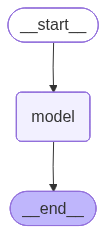

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke(
    input={"question": "What's the name of Ash's first pokémon?"},
)

In [ ]:
result

{'question': "What's the name of Ash's first pokémon?",
 'response': "Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series."}

### Um Agente com Múltiplos Passos
___

Vamos criar um agente que executa duas tarefas de LLM em sequência, com dois nós entre o START e o END.

Missão do Agente: Criar um "`Assistente de Perguntas`" que primeiro reformula a pergunta do usuário, para
ser mais clara e em seguida, responde a essa nova pergunta reformulada.


ARQUITETURA:
    >>> Estado(State) - pergunta original, pergunta reformulada e a resposta final.

In [ ]:
from typing import TypedDict

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph

# Configuração do LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)


# 1. Definição do Estado
class AgentState(TypedDict):
    """Estado compartilhado para o Assistente de Perguntas com processamento em
    duas etapas.

    Este TypedDict representa o estado que flui através do workflow do LangGraph,
    servindo como memória compartilhada entre os nós especializados. O assistente
    executa um processo de duas etapas para melhorar a qualidade das respostas:

    1. **Clarificação da Pergunta**: Um nó especializado recebe a pergunta
    original e a reformula para ser mais clara, específica e bem estruturada.

    2. **Resposta à Pergunta Clarificada**: Um segundo nó especializado recebe
       a pergunta reformulada e gera uma resposta precisa e detalhada.

    Esta arquitetura permite que cada LLM tenha um papel específico e otimizado,
    resultando em respostas de maior qualidade através da especialização das
    tarefas.

    Attributes:
        question (str): A pergunta original fornecida pelo usuário. Este é o
            ponto de entrada do workflow e permanece inalterado para referência.
        question_clarified (str): A versão reformulada e melhorada da pergunta
            original. É gerada pelo primeiro nó (especialista em clarificação)
            e serve como entrada para o segundo nó.
        answer (str): A resposta final gerada pelo segundo nó (especialista em
            resposta) baseada na pergunta clarificada. Este é o resultado final
            do workflow.

    Exemplo de fluxo:
        Input: question = "Como fazer café?"
        Node 1: question_clarified = "Quais são os passos detalhados para
                preparar café usando métodos tradicionais como coador de papel?"
        Node 2: answer = "Para preparar café usando coador de papel:
                1) Ferva água...

    Note:
        Este estado é mutável e é atualizado incrementalmente por cada nó do
        workflow. O LangGraph gerencia automaticamente a fusão das atualizações
        retornadas por cada nó com o estado compartilhado.

    """  # noqa: D205

    original_question: str
    question_clarified: str
    answer: str

In [ ]:
# 2. Definição dos Nós
def reformulate_node(state: AgentState):  # noqa: ANN201  #type: ignore
    """Nó especializado para reformular e clarificar perguntas do usuário.

    Este nó é o primeiro estágio do workflow do Assistente de Perguntas.
    Sua função principal é receber uma pergunta original (potencialmente ambígua
    ou mal estruturada)e reformulá-la para ser mais clara, específica e
    otimizada para busca de informações.

    O nó utiliza um LLM especializado em clarificação de perguntas,
    seguindo um prompt estruturado que instrui o modelo a:
    - Tornar a pergunta mais clara e direta
    - Remover ambiguidades
    - Otimizar para busca de informações
    - Retornar apenas a pergunta reformulada, sem explicações adicionais

    Este processo de clarificação é fundamental para melhorar a qualidade das
    respostas finais, pois garante que o segundo nó (responsável pela resposta)
    trabalhe com uma pergunta bem estruturada e específica.

    Args:
        state (AgentState): O estado compartilhado do workflow. Deve conter a
        chave 'original_question' com a pergunta original do usuário.

    Returns:
        dict[str, str]: Um dicionário contendo apenas as atualizações do estado.
            Retorna {"question_clarified": reformulated_question} onde
            reformulated_question é a versão melhorada da pergunta original.

    Raises:
        KeyError: Se a chave 'original_question' não estiver presente no estado.
        AttributeError: Se o LLM não retornar um objeto com atributo 'content'.

    Example:
        >>> state = AgentState(original_question="Como fazer café?")
        >>> result = reformulate_node(state)
        >>> print(result)
        {'question_clarified': 'Quais são os passos detalhados para preparar café
    usando métodos tradicionais como coador de papel?'}

    Note:
        - Este nó segue o padrão LangGraph de retornar apenas atualizações
        parciais do estado, não o estado completo.
        - O LLM utilizado deve ser configurado com temperature baixa (0.0) para
        garantir consistência nas reformulações.
        - A função inclui logs detalhados para facilitar o debugging e
        monitoramento do workflow.

    """  # noqa: DOC502
    print("--- Entrando no NODE 1: Reformulação da Pergunta ---")
    original_question = state["original_question"]

    # * Prompt estruturado para instruir o LLM a reformular a pergunta
    prompt = [
        SystemMessage("""Sua tarefa é reformular a pergunta do usuário para que 
        ela seja mais clara, direta e otimizada para uma busca de informação.
        Retorne apenas a pergunta reformulada, sem explicações ou comentários.
        """),
        HumanMessage(original_question),
    ]

    # Invocar o LLM para reformular a pergunta
    response = llm.invoke(prompt)
    reformulated_question = response.content  # type: ignore  # noqa: PGH003
    print(f"Pergunta Reformulada: {reformulated_question}")

    # Retorna a ATUALIZAÇÃO do estado (padrão LangGraph)
    return {"question_clarified": reformulated_question}  # type: ignore  # noqa: PGH003

### Segundo NODE - Answer Node
___

In [ ]:
def answer_node(state: AgentState):  # noqa: ANN201  # type: ignore
    """Nó especializado para gerar respostas educativas baseadas em perguntas
    clarificadas.

    Este nó é o segundo estágio do workflow do Assistente de Perguntas.
    Sua função principal é receber uma pergunta já reformulada e clarificada
    pelo primeiro nó e gerar uma resposta educativa, didática e detalhada.

    O nó atua como um tutor especializado em Python, utilizando um LLM
    configurado com um prompt específico que instrui o modelo a:
    - Responder de forma clara e didática
    - Incluir exemplos de código sempre que apropriado
    - Estruturar a resposta de maneira educativa
    - Fornecer explicações detalhadas e práticas

    Este processo de resposta especializada aproveita a qualidade da pergunta
    clarificada pelo primeiro nó, resultando em respostas mais precisas e úteis
    para o usuário final.

    Args:
        state (AgentState): O estado compartilhado do workflow. Deve conter a
        chave 'question_clarified' com a pergunta já reformulada pelo primeiro
        nó.

    Returns:
        dict[str, str]: Um dicionário contendo apenas as atualizações do estado.
            Retorna {"answer": answer} onde answer é a resposta educativa gerada
            pelo LLM especializado em tutoria de Python.

    Raises:
        KeyError: Se a chave 'question_clarified' não estiver presente no estado.
        AttributeError: Se o LLM não retornar um objeto com atributo 'content'.

    Example:
        >>> state = AgentState(question_clarified="Como implementar uma função
        ... que calcula o fatorial de um número em Python?")
        >>> result = answer_node(state)
        >>> print(result)
        {'answer': 'Para calcular o fatorial de um número em Python, você pode
        usar uma função recursiva...'}

    Note:
        - Este nó depende da saída do primeiro nó (reformulate_node) para
        funcionar corretamente.
        - O LLM é configurado com um prompt específico para tutoria de Python,
        garantindo respostas educativas e com exemplos práticos.
        - A função inclui logs para monitoramento, mostrando os primeiros 100
        caracteres da resposta gerada.
        - Segue o padrão LangGraph de retornar apenas atualizações parciais do
        estado.
        - A resposta final será armazenada no estado compartilhado e pode ser
        acessada por outros componentes do sistema.

    Workflow Integration:
        Este nó é tipicamente conectado após o reformulate_node no workflow,
        criando um pipeline de duas etapas:
        1. Clarificação da pergunta (reformulate_node)
        2. Geração da resposta educativa (answer_node)

    """  # noqa: D205, DOC502
    print("--- ENTRANDO NO NÓ DE RESPOSTA ---")
    reformulated_question = state["question_clarified"]

    # Prompt estruturado para instruir o LLM a responder como tutor especializado
    prompt = [
        SystemMessage("""Você é um tutor expert em Python. Responda de forma clara, 
        didática e sempre que possível, com exemplos de código. Estruture sua 
        resposta de maneira educativa, explicando conceitos de forma progressiva 
        e fornecendo exemplos práticos quando apropriado."""),
        HumanMessage(reformulated_question),
    ]

    # * Invocar o LLM para gerar a resposta educativa
    response = llm.invoke(prompt)
    answer = response.content  # type: ignore  # noqa: PGH003
    print(f"Resposta Gerada: {answer[:100]}...")

    # * Retorna a ATUALIZAÇÃO final para o estado (padrão LangGraph)
    return {"answer": answer}  # type: ignore  # noqa: PGH003

### Construção do workflow
___

In [ ]:
# * 3. Construção do Workflow
workflow = StateGraph(AgentState)

# Adiciona os nós
workflow.add_node("reformulate", reformulate_node)
workflow.add_node("answer", answer_node)

# Define as arestas (o caminho)
workflow.set_entry_point("reformulate")  # O ponto de partida é o nó de reformulação
workflow.add_edge(
    "reformulate", "answer"
)  # Depois de reformular, vá para o nó de resposta
workflow.add_edge("answer", END)  # Depois de responder, termine

# 4. Compilação e Visualização
graph = workflow.compile()

In [ ]:
# Define as arestas (o caminho)
workflow.set_entry_point("reformulate")  # O ponto de partida é o nó de reformulação
workflow.add_edge(
    "reformulate", "answer"
)  # Depois de reformular, vá para o nó de resposta
workflow.add_edge("answer", END)  # Depois de responder, termine

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


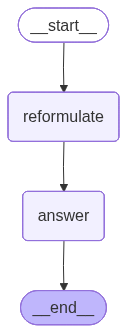

In [ ]:
# 4. Compilação e Visualização
graph = workflow.compile()

# Visualizar o grafo para confirmar a estrutura
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 5. Execução
pergunta_usuario = "Como eu crio um decorator em python, preciso de alguma biblioteca?"
initial_state = {"original_question": pergunta_usuario}

final_state = graph.invoke(initial_state)

print("\n--- RESULTADO FINAL ---")
print(f"Pergunta Original: {final_state['original_question']}")
print(f"Pergunta Reformulada: {final_state['question_clarified']}")
print(f"Resposta: {final_state['answer']}")

--- Entrando no NODE 1: Reformulação da Pergunta ---
Pergunta Reformulada: Como criar um decorator em Python? É necessário usar alguma biblioteca?
--- ENTRANDO NO NÓ DE RESPOSTA ---
Resposta Gerada: Um decorator em Python é uma função que permite modificar o comportamento de outra função ou método....

--- RESULTADO FINAL ---
Pergunta Original: Como eu crio um decorator em python, preciso de alguma biblioteca?
Pergunta Reformulada: Como criar um decorator em Python? É necessário usar alguma biblioteca?
Resposta: Um decorator em Python é uma função que permite modificar o comportamento de outra função ou método. Decorators são uma maneira poderosa e flexível de adicionar funcionalidades a funções existentes sem modificar seu código diretamente. 

### Estrutura Básica de um Decorator

Um decorator é uma função que recebe outra função como argumento e retorna uma nova função que geralmente estende ou altera o comportamento da função original. Vamos ver como isso funciona passo a passo.

#

###  Exercício Proposto: `O Agente de Viagens Inteligente`

A ideia é construir um agente que cria um mini roteiro de viagem personalizado. O agente terá que tomar uma decisão (o condicional) e, para a tarefa de gerar o roteiro, ele usará uma Chain pré-definida para garantir que a saída seja sempre bem estruturada.

A Missão:

O agente receberá do usuário um destino (ex: "Rio de Janeiro") e um tipo de viagem (ex: "praia e relaxamento"). Com base no tipo de viagem, ele deve gerar um roteiro simples de 3 dias.

A `chain` - a ferramenta especializada

Uma ferramenta específica e reutilizável: `Chain` para gerar roteiros, recebe um tema e um local e
e entrega um roteiro em um formato JSON estruturado.

1. Definição de estado ?
2. Configuração do LLM
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

3. parser = JsonOutputToolsParser()
4. Prompt -> LLM -> Parser(JSON)

# Definição da classe em python.
class AgenteDeViagens:
    # ATRIBUTOS (O ESTADO)
    def __init__(self, local: str, tipo_viagem: str):
        self.local: str = local
        self.tipo_viagem: str = tipo_viagem
        self.roteiro: list = [] # Começa vazio

Em **`LangGraph`** se traduz para:

In [ ]:
class AgentState(TypedDict):
    local: str
    tipo_viagem: str
    roteiro: list

`NODES`: Os nós são como os métodos da nossa classe. Cada nó é uma função que realiza uma ação, lendo e modificando os "atributos" (o estado).

In [ ]:
class AgenteDeViagens:
    # ... atributos ...

    # MÉTODOS (OS NÓS)
    def classificar_viagem(self) -> str:
        # Lógica para decidir o tipo de roteiro...
        if self.tipo_viagem == "praia":
            return "roteiro_praia"
        return "roteiro_aventura"

    def gerar_roteiro_praia(self):
        # Lógica para criar um roteiro de praia...
        tema = "atividades relaxantes na praia e vida noturna"
        self.roteiro = self._ferramenta_de_roteiro(self.local, tema)

    def gerar_roteiro_aventura(self):
        # Lógica para criar um roteiro de aventura...
        tema = "trilhas, montanhismo e exploração"
        self.roteiro = self._ferramenta_de_roteiro(self.local, tema)

 No `LangGraph`serão nossos três nós: `classificar_viagem_node`, `gerar_roteiro_praia_node`, e `gerar_roteiro_aventura_node`.

Ferramenta: **"tool calling"**

Prompt -> LLM -> Parser(JSON) 

`JsonOutputParser`

Aresta Condicional do langGraph é:  if/elif/else que conecta os nós -- executa a lógica de controle principal

In [ ]:
# O que a Aresta Condicional faz:
resultado_da_classificacao = self.classificar_viagem()

if resultado_da_classificacao == "roteiro_praia":
    self.gerar_roteiro_praia()
elif resultado_da_classificacao == "roteiro_aventura":
    self.gerar_roteiro_aventura()

No LangGraph, configuramos isso com a função `workflow.add_conditional_edges()`

1. Construir a Ferramenta Especializada --(A Chain de Roteiro)--

    Objetivo: Criar uma chain que recebe `local` e `tema` e sempre retorna um <u>**`dicionário`**</u>

Componentes:
    a. Parser: `JsonOutputParser`. Para torná-lo robusto, vamos definir a estrutura de saída que queremos com pydantic.
    b. Prompt: `PromptTemplate` que instrui o LLM a criar o roteiro e a formatar a saída de acordo com a estrutura do nosso **parser**.
    c. LLM: `ChatOpenAI`
    d. estrutura: chain = prompt | llm | parser -> **`tool calling`**

2. Definir a estrutura de dados principal: <u><span style="color:red; font-weight:bold">AgentState</span></u>.
    * <u>`TypedDict`</u> com os campos local, tipo_viagem e roteiro

3. Construir os <u><span style="color:red; font-weight:bold">NODES</span></u> do **LangGraph**
    * `classificar_viagem_node`: Recebe o estado, lê tipo_viagem e retorna a string de decisão (`"roteiro_praia"` ou `"roteiro_aventura"`).
    * `gerar_roteiro_praia_node`: Recebe o estado, define o tema **"praia"** e invoca a Chain do Passo 1. Retorna a atualização {"roteiro": ...}.
    * `gerar_roteiro_aventura_node`: Mesmo que o anterior, mas com o tema **"aventura"**.

4. Montar e Conectar o Grafo:
    * Criar o StateGraph.
    * Definir o classificar_viagem_node como o ponto de entrada.
    * Usar add_conditional_edges para criar a lógica do if, conectando o classificador aos nós de geração de roteiro.
    * Conectar os nós de roteiro ao END.


Objetivo final do agente?

"`Gerar um roteiro de viagem personalizado com base no destino e no tipo de viagem`"

Fase 1: CONCEITO (O Papel e a Caneta - 10 minutos)
Missão: Qual o objetivo final do agente? Escreva em uma única frase.

Ex: "Gerar um roteiro de viagem personalizado com base no destino e no tipo de viagem."

Fluxograma: Desenhe o fluxo! Use caixas para os Nós, losangos para as Decisões (Condicionais) e setas para as Arestas. Este é o passo mais importante.

Fase 2: ESTRUTURA (O Esqueleto do Código - 15 minutos)
Modelar o Estado: Com base no que precisa ser passado entre as caixas do seu fluxograma, defina a class AgentState(TypedDict).

Definir as Ferramentas: Se houver tarefas repetitivas ou especializadas (como gerar um JSON), crie as Chains ou funções auxiliares primeiro. Teste-as de forma isolada para garantir que funcionam.

Fase 3: IMPLEMENTAÇÃO (A Lógica - 30 minutos)
Codificar os Nós: Escreva uma função Python para cada caixa do seu fluxograma.

Montar o Grafo: Use o LangGraph para traduzir seu fluxograma em código (add_node, add_conditional_edges, set_entry_point, etc.).

Fase 4: VALIDAÇÃO (O Teste - 5 minutos)
Visualizar: Gere o diagrama Mermaid para garantir que o grafo em código corresponde ao seu desenho da Fase 1.

Executar e Depurar: Teste com diferentes entradas para verificar se todos os caminhos (condicionais) funcionam como esperado.

🏗️ Guia Prático: Construindo um Agente com LangGraph em 4 Fases
Este guia divide o processo de criação de um agente em quatro fases claras, desde a concepção da ideia até a validação final. Siga os passos para transformar seu conceito em um agente funcional.

Fase 1: ✍️ CONCEITO (O Papel e a Caneta - 10 minutos)
Nesta fase, o objetivo é planejar antes de codificar. Um bom planejamento economiza horas de depuração.

🎯 Missão
Defina o objetivo principal do seu agente em uma única frase clara e concisa.

Exemplo: "Gerar um roteiro de viagem personalizado com base no destino e no tipo de viagem do usuário."

🗺️ Fluxograma
Desenhe o fluxo de execução do seu agente. Este é o passo mais crítico de todo o processo.

* Caixas ([]): Representam os Nós (funções que executam uma tarefa).
* Losangos (<>): Representam as Decisões (lógica condicional que define o próximo passo).
* Setas (->): Representam as Arestas (as conexões que definem o fluxo).

`Fase 2: 🏛️ ESTRUTURA (O Esqueleto do Código - 15 minutos)`
Com o plano em mãos, agora criamos a estrutura de dados e as ferramentas que o agente usará.

📦 Modelar o Estado (`AgentState`)
Com base no que precisa ser passado entre as caixas do seu fluxograma, defina a estrutura de dados principal.
```python
# O que seu agente precisa saber e carregar entre os passos?
class AgentState(TypedDict):
    # Ex: destino, tipo_viagem, roteiro_gerado, etc.
```

🛠️ Definir as Ferramentas (Chains e Funções)
Identifique tarefas repetitivas ou especializadas (como gerar um JSON ou buscar em uma API).

Crie Chains ou funções Python para essas tarefas.
Teste-as de forma isolada para garantir que funcionam perfeitamente antes de integrá-las ao grafo.


`Fase 3: ⚙️ IMPLEMENTAÇÃO (A Lógica - 30 minutos)`
É hora de traduzir o fluxograma e as ferramentas em um grafo funcional.

फंक्शन Codificar os Nós
Escreva uma função Python para cada caixa do seu fluxograma da Fase 1. Cada função receberá o state e retornará um dicionário com as atualizações para esse state.

🔗 Montar o Grafo
Use o StateGraph do LangGraph para traduzir seu fluxograma em código:

* graph.add_node(...): Adiciona as funções que você criou.
* graph.add_conditional_edges(...): Implementa a lógica dos losangos do seu desenho.
* graph.set_entry_point(...): Define onde o fluxo começa.
* graph.set_finish_point(...): Define onde o fluxo termina.

`Fase 4: ✅ VALIDAÇÃO (O Teste Final - 5 minutos)`
Verifique se o que você construiu corresponde ao que você planejou.

📊 Visualizar o Grafo
Gere um diagrama (por exemplo, em formato Mermaid ou PNG) a partir do seu objeto graph. Compare-o com o seu desenho da Fase 1 para garantir que a lógica e as conexões estão corretas.

🚀 Executar e Depurar
Teste o agente com diferentes entradas para garantir que:

Todos os caminhos possíveis (as rotas condicionais) funcionam como esperado.
O estado final (AgentState) contém os resultados corretos.

In [ ]:
from pydantic import BaseModel, Field


# Define a estrutura de dados que esperamos como saída.
class Itinerary(BaseModel):
    """Define a estrutura de um roteiro de viagem."""

    roteiro: list[str] = Field(
        description="""Uma lista contendo o roteiro de 3 dias, onde cada item da lista é
                    uma string para um dia."""
    )

In [ ]:
from langchain_core.output_parsers import JsonOutputParser

# Cria um parser que espera um JSON formatado de acordo com o modelo Itinerary.
parser = JsonOutputParser(pydantic_object=Itinerary)

In [ ]:
from langchain_core.prompts import PromptTemplate

# Pegamos as instruções de formatação diretamente do parser.
# Isso garante que o prompt e o parser estejam sempre em sincronia.
format_instructions = parser.get_format_instructions()

# Criamos o template do prompt.
prompt_template = """Crie um roteiro de viagem de 3 dias para o local: {local}.
O tema da viagem é: {tema}.

A resposta deve ser um roteiro conciso e direto.

{format_instructions}
"""

# Criamos o objeto de prompt final.
prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["local", "tema"],
    partial_variables={"format_instructions": format_instructions},
)

In [ ]:
import json
import os

from dotenv import load_dotenv
from langchain_core.runnables import Runnable
from langchain_openai import ChatOpenAI

# Carrega as variáveis do arquivo .env
load_dotenv()

# Pega a chave da OpenAI das variáveis de ambiente
openai_api_key = os.getenv("OPENAI_API_KEY")

# Verifica se a chave foi carregada
if not openai_api_key:
    error_message = "OPENAI_API_KEY não encontrada no arquivo .env"
    raise ValueError(error_message)

# Inicializa o modelo com a chave
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)


# Monta a chain final usando LangChain Expression Language (LCEL)
def create_itinerary_chain() -> Runnable:  # type: ignore  # noqa: PGH003
    """Cria uma ferramenta de geração de roteiros de viagem.

    Returns:
        _type_: _description_.

    """
    return prompt | llm | parser  # type: ignore  # noqa: PGH003


itinerary_chain = create_itinerary_chain()  # pyright: ignore[reportUnknownVariableType]

# --- TESTE ISOLADO ---
print("--- Testando a itinerary_chain ---")

# 1. Defina o dicionário de entrada em uma variável primeiro
user_input = {
    "local": "Kyoto, Japão",
    "tema": "templos históricos e cultura tradicional",
}

# 2. Agora use a variável na chamada do invoke
response = itinerary_chain.invoke(user_input)  # type: ignore  # noqa: PGH003

# ==========================================================
# . Impressão formatada
# ==========================================================
print("\n" + "=" * 50)
print("🗺️  Roteiro de Viagem Gerado")

# 3. Agora a variável 'user_input' existe e pode ser usada aqui
print(f"📍 Destino: {user_input['local']}")
print(f"🎭 Tema: {user_input['tema']}")

# ==========================================================
# . Impressão formatada
# ==========================================================
print("\n" + "=" * 50)
print("🗺️  Roteiro de Viagem Gerado")
print(f"📍 Destino: {user_input['local']}")
print(f"🎭 Tema: {user_input['tema']}")
print("-" * 50)

if response and "roteiro" in response:
    for i, dia in enumerate(response["roteiro"], 1):
        print(f"👉 {dia}")
else:
    print("⚠️ Não foi possível gerar um roteiro detalhado.")

print("=" * 50)

# ==========================================================
# 7. Debug
# ==========================================================
print(f"\nTipo da resposta final: {type(response)}")
# Usando json.dumps para uma impressão "pretty-print"
print("Conteúdo da resposta (formatado como JSON):")
print(json.dumps(response, indent=2, ensure_ascii=False))

--- Testando a itinerary_chain ---

🗺️  Roteiro de Viagem Gerado
📍 Destino: Kyoto, Japão
🎭 Tema: templos históricos e cultura tradicional

🗺️  Roteiro de Viagem Gerado
📍 Destino: Kyoto, Japão
🎭 Tema: templos históricos e cultura tradicional
--------------------------------------------------
👉 Dia 1: Visita ao Templo Kinkaku-ji (Pavilhão Dourado) pela manhã, seguido de um passeio pelo Jardim do Templo. À tarde, explore o Templo Ryoan-ji e sua famosa pedra zen. Finalize o dia no bairro de Arashiyama, visitando a Floresta de Bambu e o Templo Tenryu-ji.
👉 Dia 2: Comece o dia no Templo Fushimi Inari Taisha, famoso por seus milhares de torii vermelhos. À tarde, visite o Templo Tofuku-ji e seus belos jardins. Termine o dia no bairro de Gion, onde você pode ver maikos e desfrutar de um jantar tradicional.
👉 Dia 3: Visite o Templo Kiyomizu-dera pela manhã, aproveitando a vista panorâmica da cidade. Depois, explore as ruas históricas de Higashiyama, parando em lojas de artesanato local. À tarde,

* local: str
* tipo_viagem: str
* roteiro: list[str]

In [ ]:
from typing import TypedDict


class AgentState(TypedDict):
    """Define a memória compartilhada (estado) para o Agente de Viagens.

    É a "ficha de processo" que carrega todas as informações necessárias
    e os resultados através do workflow.

    Attributes:
        local: O destino da viagem fornecido pelo usuário (Entrada).
        tipo_viagem: O tipo de viagem desejado, ex: "praia" (Entrada).
        roteiro: A lista de strings com o roteiro final gerado (Saída).

    """

    local: str
    tipo_viagem: str
    roteiro: list[str]
    route: str

In [ ]:
def classificar_viagem_node(state: AgentState) -> dict[str, str]:
    """Classifica o tipo de viagem e atualiza o estado com a rota escolhida.

    Analisa o 'tipo_viagem' no estado e decide qual o próximo passo,
    atualizando o estado com a rota escolhida.

    Args:
        state (AgentState): O estado atual do workflow.

    Returns:
        dict: Um dicionário contendo a chave 'route' com o valor da rota escolhida.

    """
    print("\n--- [NÓ DE DECISÃO: Classificando Tipo de Viagem] ---")
    tipo_viagem = state["tipo_viagem"].lower()

    if "praia" in tipo_viagem:
        print("  > Decisão: Roteiro de Praia.")
        return {"route": "gerar_roteiro_praia"}  # pyright: ignore[reportUnknownVariableType]
    print("  > Decisão: Roteiro de Aventura.")
    return {"route": "gerar_roteiro_aventura"}  # type: ignore

In [ ]:
def gerar_roteiro_praia_node(state: AgentState) -> dict[str, list[str]]:
    """Nó especialista que gera um roteiro de praia usando a itinerary_chain.

    Args:
        state (AgentState): O estado atual do workflow, contendo pelo menos a chave
    'local'.

    Returns:
        dict: Um dicionário com a chave 'roteiro' contendo a lista de strings do roteiro
    gerado.

    """
    print("\n--- [NÓ ESPECIALISTA: Gerando Roteiro de Praia] ---")

    # 1. Define o tema específico para este nó
    tema_da_viagem = "atividades relaxantes na praia e vida noturna"

    # 2. Pega o local que já está no estado
    local_da_viagem = state["local"]

    print(
        f"  > Usando a chain para o local: '{local_da_viagem}' "
        f"com o tema '{tema_da_viagem}'"
    )

    # 3. Invoca a nossa ferramenta especializada (a chain)
    resultado_chain = itinerary_chain.invoke(  # pyright: ignore[reportUnknownMemberType] # type: ignore  # noqa: PGH003
        {
            "local": local_da_viagem,
            "tema": tema_da_viagem,
        }
    )

    # 4. Retorna a atualização para o estado do grafo
    print("  > Roteiro de praia gerado com sucesso.")
    return {"roteiro": resultado_chain["roteiro"]}  # type: ignore  # noqa: PGH003

In [ ]:
def gerar_roteiro_aventura_node(state: AgentState) -> dict[str, list[str]]:
    """Nó especialista que gera um roteiro de aventura usando a itinerary_chain.

    Este nó recebe o estado atual, define o tema de aventura, invoca a ferramenta
    especializada para gerar o roteiro e retorna a atualização do estado.

    Returns:
        dict[str, list[str]]: Um dicionário com a chave 'roteiro' contendo a lista de
    strings do roteiro gerado.

    """
    print("\n--- [NÓ ESPECIALISTA: Gerando Roteiro de Aventura] ---")

    # 1. Define o tema específico para este nó
    tema_da_viagem = "trilhas, montanhismo e exploração da natureza"

    # 2. Pega o local que já está no estado
    local_da_viagem = state["local"]

    print(
        f"> Usando a chain para o local: '{local_da_viagem}' "
        f"com o tema '{tema_da_viagem}'"
    )

    # 3. Invoca a mesma ferramenta especializada
    resultado_chain = itinerary_chain.invoke(  # pyright: ignore[reportUnknownMemberType] # type: ignore  # noqa: PGH003
        {"local": local_da_viagem, "tema": tema_da_viagem}
    )

    # 4. Retorna a atualização para o estado do grafo
    print("  > Roteiro de aventura gerado com sucesso.")
    return {"roteiro": resultado_chain["roteiro"]}

In [ ]:
# --- Teste isolado dos nós especialistas ---
print("--- Testando os nós especialistas ---")

# Criamos um estado de teste
estado_teste = AgentState(
    local="Bariloche, Argentina", tipo_viagem="aventura", roteiro=[]
)

# Testamos o nó de aventura
resultado_aventura = gerar_roteiro_aventura_node(estado_teste)

# Imprimimos o resultado do teste usando a formatação com 'rich' ou 'json'
# ... (código de impressão bonita aqui) ...

--- Testando os nós especialistas ---

--- [NÓ ESPECIALISTA: Gerando Roteiro de Aventura] ---
> Usando a chain para o local: 'Bariloche, Argentina' com o tema 'trilhas, montanhismo e exploração da natureza'
  > Roteiro de aventura gerado com sucesso.


--- Visualização da Arquitetura do Grafo ---


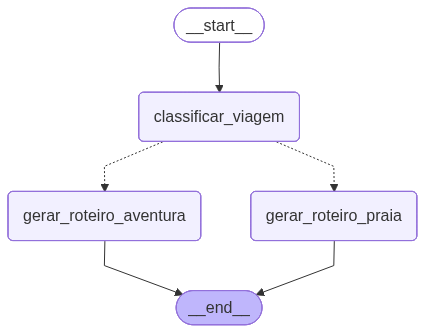


--- Testando o Agente de Viagens (PRAIA) ---

--- [NÓ DE DECISÃO: Classificando Tipo de Viagem] ---
  > Decisão: Roteiro de Praia.

--- [NÓ ESPECIALISTA: Gerando Roteiro de Praia] ---
  > Usando a chain para o local: 'Porto de Galinhas, Brasil' com o tema 'atividades relaxantes na praia e vida noturna'
  > Roteiro de praia gerado com sucesso.

🗺️  Roteiro de Viagem Final
📍 Destino: Porto de Galinhas, Brasil
🎭 Tema: quero relaxar na praia
--------------------------------------------------
👉 Dia 1: Dia 1: Chegada em Porto de Galinhas, check-in no hotel. Passeio relaxante nas piscinas naturais pela manhã. Almoço em um restaurante à beira-mar. Tarde livre para relaxar na praia. À noite, jantar em um bar de praia com música ao vivo.
👉 Dia 2: Dia 2: Manhã de yoga na praia para começar o dia relaxando. Almoço em um restaurante local. Tarde de passeio de jangada para explorar as praias vizinhas. À noite, visita a um bar animado no centro de Porto de Galinhas.
👉 Dia 3: Dia 3: Manhã livre para 

In [ ]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph

# ==============================================================================
# 1. INICIALIZAÇÃO DO GRAFO
# Criamos a "planta da fábrica", dizendo que ela usará a estrutura do AgentState.
# ==============================================================================
workflow = StateGraph(AgentState)

# ==============================================================================
# 2. ADIÇÃO DOS NÓS
# Registramos todas as nossas "estações de trabalho" no workflow.
# ==============================================================================
workflow.add_node("classificar_viagem", classificar_viagem_node)
workflow.add_node("gerar_roteiro_praia", gerar_roteiro_praia_node)
workflow.add_node("gerar_roteiro_aventura", gerar_roteiro_aventura_node)

# ==============================================================================
# 3. DEFINIÇÃO DAS ARESTAS E DO FLUXO
# Aqui está a parte mais importante: conectar tudo.
# ==============================================================================

# O ponto de entrada: Todo processo começa no nó de classificação.
workflow.set_entry_point("classificar_viagem")

# A ARESTA CONDICIONAL CORRIGIDA
workflow.add_conditional_edges(
    # O nó de onde a decisão parte.
    "classificar_viagem",
    # ! CORREÇÃO: A função lambda agora LÊ a chave 'route' do estado
    # para decidir qual caminho seguir.
    lambda state: state["route"],  # type: ignore  # noqa: FURB118, PGH003
    # O mapa que conecta a decisão ao próximo nó.
    {
        "gerar_roteiro_praia": "gerar_roteiro_praia",
        "gerar_roteiro_aventura": "gerar_roteiro_aventura",
    },
)

# Os pontos de saída: Depois de qualquer um dos nós especialistas, o trabalho termina.
workflow.add_edge("gerar_roteiro_praia", END)
workflow.add_edge("gerar_roteiro_aventura", END)

# ==============================================================================
# 4. COMPILAÇÃO E VISUALIZAÇÃO
# Pegamos nossa planta e "construímos a máquina".
# ==============================================================================
agent = workflow.compile()

# Vamos visualizar o grafo para confirmar que nossa lógica está correta!
print("--- Visualização da Arquitetura do Grafo ---")
display(Image(agent.get_graph().draw_mermaid_png()))

# ==============================================================================
# 5. EXECUÇÃO FINAL
# Agora, vamos testar o agente completo.
# ==============================================================================
print("\n--- Testando o Agente de Viagens (PRAIA) ---")

# Teste 1: Viagem de praia
input_praia = AgentState(
    local="Porto de Galinhas, Brasil", tipo_viagem="quero relaxar na praia", roteiro=[]
)
resultado_praia = agent.invoke(input_praia)

# Imprime o resultado final formatado
print("\n" + "=" * 50)
print("🗺️  Roteiro de Viagem Final")
print(f"📍 Destino: {resultado_praia['local']}")
print(f"🎭 Tema: {resultado_praia['tipo_viagem']}")
print("-" * 50)
for i, dia in enumerate(resultado_praia["roteiro"], 1):
    print(f"👉 Dia {i}: {dia}")
print("=" * 50)


print("\n\n--- Testando o Agente de Viagens (AVENTURA) ---")

# Teste 2: Viagem de aventura
input_aventura = AgentState(
    local="Chapada Diamantina, Brasil",
    tipo_viagem="muita aventura e trilhas",
    roteiro=[],
)
resultado_aventura = agent.invoke(input_aventura)

# Imprime o resultado final formatado
print("\n" + "=" * 50)
print("🗺️  Roteiro de Viagem Final")
print(f"📍 Destino: {resultado_aventura['local']}")
print(f"🎭 Tema: {resultado_aventura['tipo_viagem']}")
print("-" * 50)
for dia in resultado_praia["roteiro"]:
    print(f"👉 {dia}")
print("=" * 50)